In [3]:
import torch
from datasets import load_dataset
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Create the pipeline
mask_generator = SAM2AutomaticMaskGenerator.from_pretrained("facebook/sam2-hiera-large")
# Load the dataset
dataset = load_dataset("ntudlcv/dlcv_2024_final1")

/home/tomchen/mambaforge/envs/final/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import numpy as np
from PIL import Image


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    img = np.zeros((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 3))
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3)])
        img[m] = color_mask 

    img *= 255

    return Image.fromarray(img.astype(np.uint8))

In [10]:
from torch.utils.data import DataLoader
import numpy as np


# Custom collate function to handle dictionaries with PIL images
def collate_fn(batch):
    images = [item["image"] for item in batch]
    other_properties = [
        {k: v for k, v in item.items() if k != "image"} for item in batch
    ]
    return images, other_properties


# Create a DataLoader for the dataset with the custom collate function
data_loader = DataLoader(
    dataset["train"], batch_size=8, shuffle=True, collate_fn=collate_fn
)

# Load only one batch
images, other_properties = next(iter(data_loader))

# Get depth maps for the images
masks = []
for image in images:
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        np_image = np.array(image.convert("RGB"))
        masks.append(show_anns(mask_generator.generate(np_image)))

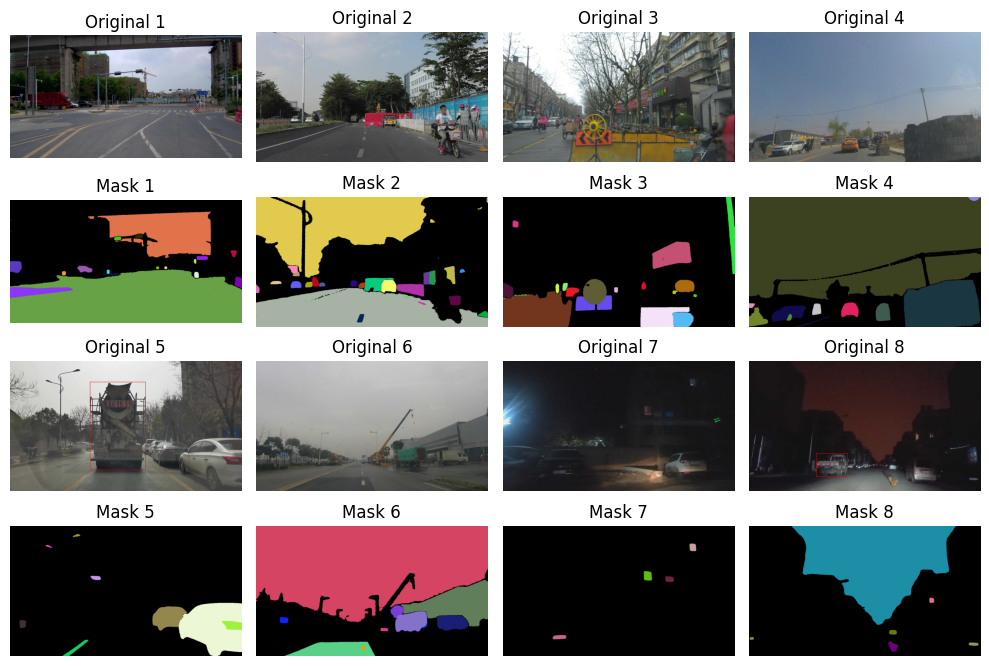

In [11]:
import matplotlib.pyplot as plt

# Plot a grid showing the original images and the depth maps
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7))

for i, (image, mask) in enumerate(zip(images, masks)):
    row = (i // 4) * 2
    col = i % 4

    axes[row, col].imshow(image)
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Original {i+1}")

    axes[row + 1, col].imshow(mask)
    axes[row + 1, col].axis("off")
    axes[row + 1, col].set_title(f"Mask {i+1}")

plt.tight_layout(h_pad=0)
plt.show()